# Import packages

In [ ]:
%pip install -r requirements.txt -i http://pypi.douban.com/simple/ --trusted-host pypi.douban.com

In [22]:
import os
import random
import requests
import time
import typing
from typing import Any, Callable, Dict, Type
import warnings

from boruta import BorutaPy
import lightgbm
from matplotlib import pyplot as plt
import numpy as np
import optuna
from optuna.visualization import plot_optimization_history, plot_contour, plot_edf, \
    plot_intermediate_values, plot_optimization_history, plot_parallel_coordinate, \
    plot_param_importances, plot_slice
import pandas as pd
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.callbacks import MaskableEvalCallback
from sb3_contrib.common.maskable.evaluation import evaluate_policy
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.callbacks import StopTrainingOnNoModelImprovement
from stable_baselines3.common.logger import configure
from stable_baselines3.common.monitor import Monitor
import stockstats
import torch as th
import tushare
import yfinance as yf

from environment.SingleStockTradingEnv import SingleStockTradingEnv
from maskable.MaskableDQN import MaskableDQN
from maskable.MaskableIQN import MaskableIQN
from maskable.MaskableQRDQN import MaskableQRDQN
from utils.sample_funcs import *
from utils.utils import *

# Config

In [23]:
warnings.simplefilter(action='ignore', category=FutureWarning)

TRAIN_START_DAY = '2008-01-01'
TRAIN_END_DAY = '2016-12-31'
TEST_START_DAY = '2017-01-01'
TEST_END_DAY = '2019-12-31'
TRADE_START_DAY = '2020-01-01'
TRADE_END_DAY = '2022-12-31'

# Setup directories
DATA_SAVE_DIR = 'datasets'
MODEL_DIR = 'models'
TENSORBOARD_LOG_DIR = 'tensorboard_log'
RAW_DATA_DIR = os.path.join(DATA_SAVE_DIR, 'raw')
RAW_DATA_WITHIN_RANGE_DIR = os.path.join(DATA_SAVE_DIR, f'raw_{TRAIN_START_DAY}_{TRADE_END_DAY}')
CLEAN_DATA_DIR = os.path.join(DATA_SAVE_DIR, 'clean')
PREPROCESSED_DATA_DIR = os.path.join(DATA_SAVE_DIR, 'preprocessed')
PREPROCESSED_CSI300_DIR = os.path.join(PREPROCESSED_DATA_DIR, 'CSI300')

check_and_make_directories([DATA_SAVE_DIR, MODEL_DIR, TENSORBOARD_LOG_DIR, \
     RAW_DATA_DIR, RAW_DATA_WITHIN_RANGE_DIR, CLEAN_DATA_DIR, \
     PREPROCESSED_DATA_DIR, PREPROCESSED_CSI300_DIR])

tushare_token = '2bf5fdb105eefda26ef27cc9caa94e6f31ca66e408f7cc54d4fce032'

# Download data

## Download CSI300-components ticker list

In [3]:
def download_csi300_component_ticker_list(url: str, download_dir: str) -> List[str]:
    download_file_name = url.split('/')[-1]
    download_file_path = os.path.join(download_dir, download_file_name)
    if not os.path.exists(download_file_path):
        r =requests.get(url)
        with open(download_file_path, 'wb') as f:
            f.write(r.content)
            f.close()
    df = pd.read_excel(download_file_path)
    df.loc[df['交易所Exchange'] == '上海证券交易所', 'suffix'] = 'SS'
    df.loc[df['交易所Exchange'] == '深圳证券交易所', 'suffix'] = 'SZ'
    tic_list = [f'{code:06d}.{suffix}' for code, suffix in zip(df['成分券代码Constituent Code'], df['suffix'])]
    return tic_list

In [4]:
url = r'https://csi-web-dev.oss-cn-shanghai-finance-1-pub.aliyuncs.com/static/html/csindex/public/uploads/file/autofile/cons/000300cons.xls'
tic_list = download_csi300_component_ticker_list(url, DATA_SAVE_DIR)

## Download ticker history with yfinace

In [39]:
def download_ticker_with_yfince(tic_list: List[str], download_dir: str) -> List[str]:
    retry_list = []
    for tic in tic_list:
        csv_path = os.path.join(download_dir, f'{tic}.csv')
        if os.path.exists(csv_path):
            print(f'File {csv_path} already exist. Skip')
            continue
        
        ticker = yf.Ticker(tic)
        df = ticker.history(period='max')
        if df.shape[0] > 0:
            df.to_csv(csv_path)
            print(f'Download {tic}.csv')         
            time.sleep(0.1)
        else:
            retry_list.append(tic)
    
    return retry_list

In [ ]:
retry_list = download_ticker_with_yfince(tic_list, RAW_DATA_DIR)

In [ ]:
retry_list = download_ticker_with_yfince(retry_list, RAW_DATA_DIR)

## Download data with adjusted price from yfinace within range

In [45]:
for tic in tic_list:
    csv_path = os.path.join(RAW_DATA_DIR, f'{tic}.csv')
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path, index_col=False)
        start = df['Date'].iloc[0].split(' ')[0]
        end = df['Date'].iloc[-1].split(' ')[0]
        if start < TRADE_START_DAY and end > TRADE_END_DAY:
            csv_path = os.path.join(RAW_DATA_WITHIN_RANGE_DIR, f'{tic}.csv')
            if not os.path.exists(csv_path):
                df_within_range = yf.download(tic, start=TRAIN_START_DAY, end=TRADE_END_DAY)
                df_within_range.to_csv(csv_path)
        else:
            print(f'{tic}: from {start} to {end} out of range.')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

c:\ProgramData\Miniconda3\envs\FTL\lib\site-packages\yfinance\utils.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_missing[list(keys)] = _np.nan
c:\ProgramData\Miniconda3\envs\FTL\lib\site-packages\yfinance\utils.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_missing[list(keys)] = _np.nan
c:\ProgramData\Miniconda3\envs\FTL\lib\site-packages\yfinance\utils.py:613: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

# Clean data

In [5]:
def get_calendar_with_tushare(start: str, end: str) -> pd.Series:
    start = start.replace('-', '')
    end = end.replace('-', '')

    tushare.set_token(tushare_token)
    tu_pro = tushare.pro_api()
    calendar_ss = tu_pro.trade_cal(exchange='SSE', start_date=start, end_date=end, is_open=1)
    calendar_sz = tu_pro.trade_cal(exchange='SZSE', start_date=start, end_date=end, is_open=1)
    if calendar_ss.shape[0] != calendar_ss.shape[0]:
        calendar = pd.merge(calendar_ss.cal_date, calendar_sz.cal_date, on=['cal_date'], how='outer')
    else:
        calendar = calendar_ss.cal_date

    calendar = pd.to_datetime(calendar, format='%Y%m%d')
    calendar.rename('date', inplace=True)
    
    return calendar

In [6]:
def clean_data_from_yfinance(data: pd.DataFrame, calendar: pd.Series = None) -> pd.DataFrame:
    # TODO: calculate adjusted price.
    data.drop(labels=['Dividends', 'Stock Splits'], axis='columns', inplace=True)
    data.rename(columns={
        'Date': 'date',
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close' : 'close',
        'Volume' : 'volume'
        }, inplace=True)
    data['date'] = pd.to_datetime(data['date'].apply(lambda s: s.split(' ')[0]), format='%Y-%m-%d')
    data = pd.merge(calendar, data, how='left', on='date')

    return data

In [14]:
def clean_data_within_range_from_yfinance(data: pd.DataFrame, calendar: pd.Series = None) -> pd.DataFrame:
    # Use adjusted close as close
    data['Close'] = data['Adj Close'] / data['Close']
    data.rename(columns={
        'Date': 'date',
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Adj Close' : 'close',
        'Volume' : 'volume'
        }, inplace=True)

    # Adjust open high low
    data['open'] = data['open'] * data['Close']
    data['high'] = data['high'] * data['Close']
    data['low'] = data['low'] * data['Close']
    data.drop(labels=['Close'], axis='columns', inplace=True)
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

    n_rows = data.shape[0]
    data.drop_duplicates(subset=['open', 'high', 'low', 'close', 'volume'], inplace=True)
    print(f'Drop {n_rows - data.shape[0]} duplicated rows.')

    n_rows = data.shape[0]
    data = data[(data.high > data.low) & (data.high >= data.open) & (data.high >= data.close)]
    data = data[(data.low <= data.open) & (data.low <= data.close)]
    print(f'Drop {n_rows - data.shape[0]} rows with abnormal prices.')

    n_rows = data.shape[0]
    data = data[data.volume != 0]
    print(f'Drop {n_rows - data.shape[0]} rows with volume 0.')

    data = pd.merge(calendar, data, how='left', on='date')

    return data

In [15]:
NA_THRESHOLD = 0.1

calendar = get_calendar_with_tushare(TRAIN_START_DAY, TRADE_END_DAY)

na_list = []
for tic in tic_list:
    file_path = os.path.join(RAW_DATA_WITHIN_RANGE_DIR, f'{tic}.csv')
    if not os.path.exists(file_path):
        continue

    result_path = os.path.join(CLEAN_DATA_DIR, f'{tic}.csv')
    if os.path.exists(result_path):
        continue

    df = pd.read_csv(file_path, index_col=False)

    print(f'Cleaning {tic}:')
    df = clean_data_within_range_from_yfinance(df, calendar)

    len_df = df.shape[0]
    df.dropna(inplace=True)
    print(f'{len_df - df.shape[0]} rows droped from {tic}.\n')

    if df.shape[0] >= len(calendar) * (1 - NA_THRESHOLD):
        df.to_csv(result_path, index=False)
    else:
        na_list.append(tic)
        print(f'{tic}: too many NaNs, discard.')

Cleaning 601390.SS:
Drop 84 duplicated rows.
Drop 19 rows with abnormal prices.
Drop 0 rows with volume 0.
111 rows droped from 601390.SS.

Cleaning 600837.SS:
Drop 3 duplicated rows.
Drop 20 rows with abnormal prices.
Drop 0 rows with volume 0.
34 rows droped from 600837.SS.

Cleaning 600132.SS:
Drop 26 duplicated rows.
Drop 30 rows with abnormal prices.
Drop 0 rows with volume 0.
74 rows droped from 600132.SS.

Cleaning 600115.SS:
Drop 38 duplicated rows.
Drop 27 rows with abnormal prices.
Drop 0 rows with volume 0.
98 rows droped from 600115.SS.

Cleaning 600104.SS:
Drop 56 duplicated rows.
Drop 17 rows with abnormal prices.
Drop 0 rows with volume 0.
83 rows droped from 600104.SS.

Cleaning 600031.SS:
Drop 3 duplicated rows.
Drop 20 rows with abnormal prices.
Drop 0 rows with volume 0.
36 rows droped from 600031.SS.

Cleaning 002202.SZ:
Drop 14 duplicated rows.
Drop 19 rows with abnormal prices.
Drop 0 rows with volume 0.
34 rows droped from 002202.SZ.

Cleaning 300059.SZ:
Drop 52 

In [17]:
print(len(na_list))
' '.join(na_list)

141


'300059.SZ 603899.SS 603799.SS 601689.SS 600958.SS 002756.SZ 601985.SS 300529.SZ 603986.SS 601229.SS 300595.SZ 002841.SZ 601881.SS 000776.SZ 300601.SZ 300628.SZ 603659.SS 002916.SZ 601838.SS 601360.SS 603259.SS 300454.SZ 601066.SS 300760.SZ 300751.SZ 300763.SZ 600989.SS 300782.SZ 601698.SS 601236.SS 000723.SZ 600745.SS 300122.SZ 688005.SS 003816.SZ 688036.SS 688363.SS 688111.SS 601658.SS 300124.SZ 002493.SZ 600999.SS 002352.SZ 002129.SZ 002311.SZ 601336.SS 300207.SZ 002555.SZ 002594.SZ 002602.SZ 601901.SS 002601.SZ 300316.SZ 601633.SS 601669.SS 000408.SZ 601012.SS 601238.SS 601800.SS 300014.SZ 300347.SZ 603993.SS 000333.SZ 603806.SS 601618.SS 601818.SS 601021.SS 300433.SZ 300450.SZ 601211.SS 300498.SZ 601155.SS 300496.SZ 601966.SS 600919.SS 002812.SZ 600926.SS 002821.SZ 000792.SZ 600893.SS 603833.SS 603501.SS 300661.SZ 601878.SS 603882.SS 603260.SS 600025.SS 002920.SZ 300142.SZ 603486.SS 601138.SS 300750.SZ 002938.SZ 601319.SS 002475.SZ 601668.SS 002304.SZ 601688.SS 603185.SS 601615.SS

In [18]:
_, _, files = next(os.walk(CLEAN_DATA_DIR))
print(len(files))
print(files)

132
['000001.SZ.csv', '000002.SZ.csv', '000063.SZ.csv', '000069.SZ.csv', '000100.SZ.csv', '000157.SZ.csv', '000166.SZ.csv', '000301.SZ.csv', '000338.SZ.csv', '000425.SZ.csv', '000538.SZ.csv', '000568.SZ.csv', '000596.SZ.csv', '000625.SZ.csv', '000651.SZ.csv', '000661.SZ.csv', '000708.SZ.csv', '000725.SZ.csv', '000733.SZ.csv', '000768.SZ.csv', '000786.SZ.csv', '000800.SZ.csv', '000858.SZ.csv', '000876.SZ.csv', '000877.SZ.csv', '000895.SZ.csv', '000938.SZ.csv', '000963.SZ.csv', '000977.SZ.csv', '001979.SZ.csv', '002001.SZ.csv', '002007.SZ.csv', '002008.SZ.csv', '002027.SZ.csv', '002032.SZ.csv', '002049.SZ.csv', '002050.SZ.csv', '002064.SZ.csv', '002074.SZ.csv', '002120.SZ.csv', '002142.SZ.csv', '002179.SZ.csv', '002202.SZ.csv', '002230.SZ.csv', '002236.SZ.csv', '002241.SZ.csv', '002271.SZ.csv', '600000.SS.csv', '600009.SS.csv', '600010.SS.csv', '600011.SS.csv', '600015.SS.csv', '600016.SS.csv', '600018.SS.csv', '600019.SS.csv', '600028.SS.csv', '600029.SS.csv', '600030.SS.csv', '600031.S

# Feature engineering

In [9]:
# columns after init_all()
df = pd.read_csv('./datasets/clean/000001.SZ.csv', index_col=False)
stats = stockstats.StockDataFrame.retype(df)
stats.init_all()
stats.columns

Index(['open', 'high', 'low', 'close', 'volume', 'change', 'rs_14', 'rsi',
       'rsi_14', 'stochrsi', 'rate', 'middle', 'tp', 'boll', 'boll_ub',
       'boll_lb', 'macd', 'macds', 'macdh', 'ppo', 'ppos', 'ppoh', 'rsv_9',
       'kdjk_9', 'kdjk', 'kdjd_9', 'kdjd', 'kdjj_9', 'kdjj', 'cr', 'cr-ma1',
       'cr-ma2', 'cr-ma3', 'cci', 'tr', 'atr', 'high_delta', 'um', 'low_delta',
       'dm', 'pdm', 'pdm_14_ema', 'pdm_14', 'atr_14', 'pdi_14', 'pdi', 'mdm',
       'mdm_14_ema', 'mdm_14', 'mdi_14', 'mdi', 'dx_14', 'dx', 'adx', 'adxr',
       'trix', 'tema', 'vr', 'close_10_sma', 'close_50_sma', 'dma', 'vwma',
       'chop', 'log-ret', 'mfi', 'wt1', 'wt2', 'wr', 'supertrend_ub',
       'supertrend_lb', 'supertrend'],
      dtype='object')

In [35]:
X_y_filename = 'x_y.csv'
X_y_path = os.path.join(DATA_SAVE_DIR, X_y_filename)

warnings.simplefilter(action='ignore', category=RuntimeWarning)

if not os.path.exists(X_y_path):
    X_y = None

    _, _, files = next(os.walk(CLEAN_DATA_DIR))
    for file in files:
        file_path = os.path.join(CLEAN_DATA_DIR, file)
        df = pd.read_csv(file_path, index_col=False)
        stats = stockstats.StockDataFrame.retype(df)
        stats.init_all()

        # drop duplicated columns
        stats.drop_column(['rsi', 'kdjk', 'kdjd', 'kdjj'], inplace=True)

        # add additional indicators: close_14_smma, close_14_mstd, close_14_mvar, close_5_kama
        # close_5_sma, wr_6, rsi_6,
        # log differential of high, low, open and volume
        # and log2(close / open)
        stats['close_14_smma']; stats['close_14_mstd']; stats['close_14_mvar']; stats['close_5_kama']
        stats['close_5_sma'];   stats['wr_6'];  stats['rsi_6']
        stats['log_diff_high'] = np.log2(stats['high'] / stats['high_-1_s'])
        stats['log_diff_low']= np.log2(stats['low'] / stats['low_-1_s'])
        stats['log_diff_open']= np.log2(stats['open'] / stats['open_-1_s'])
        stats['log_diff_vol']= np.log2(stats['volume'] / stats['volume_-1_s'])
        stats['log_close/open'] = np.log2(stats['close'] / stats['open'])
        stats.drop_column(['high_-1_s', 'low_-1_s', 'open_-1_s', 'volume_-1_s'], inplace=True)
        stats['log-ret_1_s']
        stats.rename(columns={'log-ret_1_s': 'y'}, inplace=True)

        # drop rs_14, rs_6
        stats.drop_column(['rs_14', 'rs_6'], inplace=True)
        # Drop date column
        stats.reset_index(drop=True, inplace=True)

        # Drop nan, inf
        stats.replace([np.inf, -np.inf], np.nan, inplace=True)
        stats.dropna(inplace=True)

        if X_y is None:
            X_y = stats.copy()
        else:
            X_y = pd.concat([X_y, stats])
        print(f'Add {file} to X_y.')

X_y.to_csv(X_y_path, index=False)

Add 000001.SZ.csv to X_y.
Add 000002.SZ.csv to X_y.
Add 000063.SZ.csv to X_y.
Add 000069.SZ.csv to X_y.
Add 000100.SZ.csv to X_y.
Add 000157.SZ.csv to X_y.
Add 000166.SZ.csv to X_y.
Add 000301.SZ.csv to X_y.
Add 000338.SZ.csv to X_y.
Add 000425.SZ.csv to X_y.
Add 000538.SZ.csv to X_y.
Add 000568.SZ.csv to X_y.
Add 000596.SZ.csv to X_y.
Add 000625.SZ.csv to X_y.
Add 000651.SZ.csv to X_y.
Add 000661.SZ.csv to X_y.
Add 000708.SZ.csv to X_y.
Add 000725.SZ.csv to X_y.
Add 000733.SZ.csv to X_y.
Add 000768.SZ.csv to X_y.
Add 000786.SZ.csv to X_y.
Add 000800.SZ.csv to X_y.
Add 000858.SZ.csv to X_y.
Add 000876.SZ.csv to X_y.
Add 000877.SZ.csv to X_y.
Add 000895.SZ.csv to X_y.
Add 000938.SZ.csv to X_y.
Add 000963.SZ.csv to X_y.
Add 000977.SZ.csv to X_y.
Add 001979.SZ.csv to X_y.
Add 002001.SZ.csv to X_y.
Add 002007.SZ.csv to X_y.
Add 002008.SZ.csv to X_y.
Add 002027.SZ.csv to X_y.
Add 002032.SZ.csv to X_y.
Add 002049.SZ.csv to X_y.
Add 002050.SZ.csv to X_y.
Add 002064.SZ.csv to X_y.
Add 002074.S

# Feature selection

In [25]:
X_y_filename = 'x_y.csv'
X_y_path = os.path.join(DATA_SAVE_DIR, X_y_filename)
if 'X_y' not in locals():
    X_y = pd.read_csv(X_y_path, index_col=False)

In [36]:
X_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466090 entries, 2 to 3613
Data columns (total 79 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   open            466090 non-null  float64
 1   high            466090 non-null  float64
 2   low             466090 non-null  float64
 3   close           466090 non-null  float64
 4   volume          466090 non-null  float64
 5   change          466090 non-null  float64
 6   rsi_14          466090 non-null  float64
 7   stochrsi        466090 non-null  float64
 8   rate            466090 non-null  float64
 9   middle          466090 non-null  float64
 10  tp              466090 non-null  float64
 11  boll            466090 non-null  float64
 12  boll_ub         466090 non-null  float64
 13  boll_lb         466090 non-null  float64
 14  macd            466090 non-null  float64
 15  macds           466090 non-null  float64
 16  macdh           466090 non-null  float64
 17  ppo         

In [ ]:
# Feature selection with Boruta backend by random forest
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

feat_selector = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
    max_iter=10
)

X = np.array(X_y.drop(labels=['y']))
y = np.array(X_y['y'])
feat_selector.fit(X, y)

# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", X.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
    else:
        print("Doesn't pass the test: ",
              X.columns[i], " - Ranking: ", feat_selector.ranking_[i])

In [37]:
# Feature selection with Boruta backend by lightGBM
warnings.simplefilter("ignore", UserWarning)

model = lightgbm.LGBMRegressor(num_boost_round=100, seed=114)

feat_selector = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
    random_state=114,
    max_iter=500
)

X = np.array(X_y.drop(columns=['y']))
y = np.array(X_y['y'])
feat_selector.fit(X, y)

Iteration: 	1 / 500
Confirmed: 	0
Tentative: 	78
Rejected: 	0
Iteration: 	2 / 500
Confirmed: 	0
Tentative: 	78
Rejected: 	0
Iteration: 	3 / 500
Confirmed: 	0
Tentative: 	78
Rejected: 	0
Iteration: 	4 / 500
Confirmed: 	0
Tentative: 	78
Rejected: 	0
Iteration: 	5 / 500
Confirmed: 	0
Tentative: 	78
Rejected: 	0
Iteration: 	6 / 500
Confirmed: 	0
Tentative: 	78
Rejected: 	0
Iteration: 	7 / 500
Confirmed: 	0
Tentative: 	78
Rejected: 	0
Iteration: 	8 / 500
Confirmed: 	27
Tentative: 	15
Rejected: 	36
Iteration: 	9 / 500
Confirmed: 	27
Tentative: 	15
Rejected: 	36
Iteration: 	10 / 500
Confirmed: 	27
Tentative: 	15
Rejected: 	36
Iteration: 	11 / 500
Confirmed: 	27
Tentative: 	15
Rejected: 	36
Iteration: 	12 / 500
Confirmed: 	29
Tentative: 	10
Rejected: 	39
Iteration: 	13 / 500
Confirmed: 	29
Tentative: 	10
Rejected: 	39
Iteration: 	14 / 500
Confirmed: 	29
Tentative: 	10
Rejected: 	39
Iteration: 	15 / 500
Confirmed: 	29
Tentative: 	10
Rejected: 	39
Iteration: 	16 / 500
Confirmed: 	29
Tentative: 	

BorutaPy(estimator=LGBMRegressor(n_estimators=-848, num_boost_round=100,
                                 random_state=RandomState(MT19937) at 0x295630F0B40,
                                 seed=114),
         max_iter=500, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x295630F0B40, verbose=2)

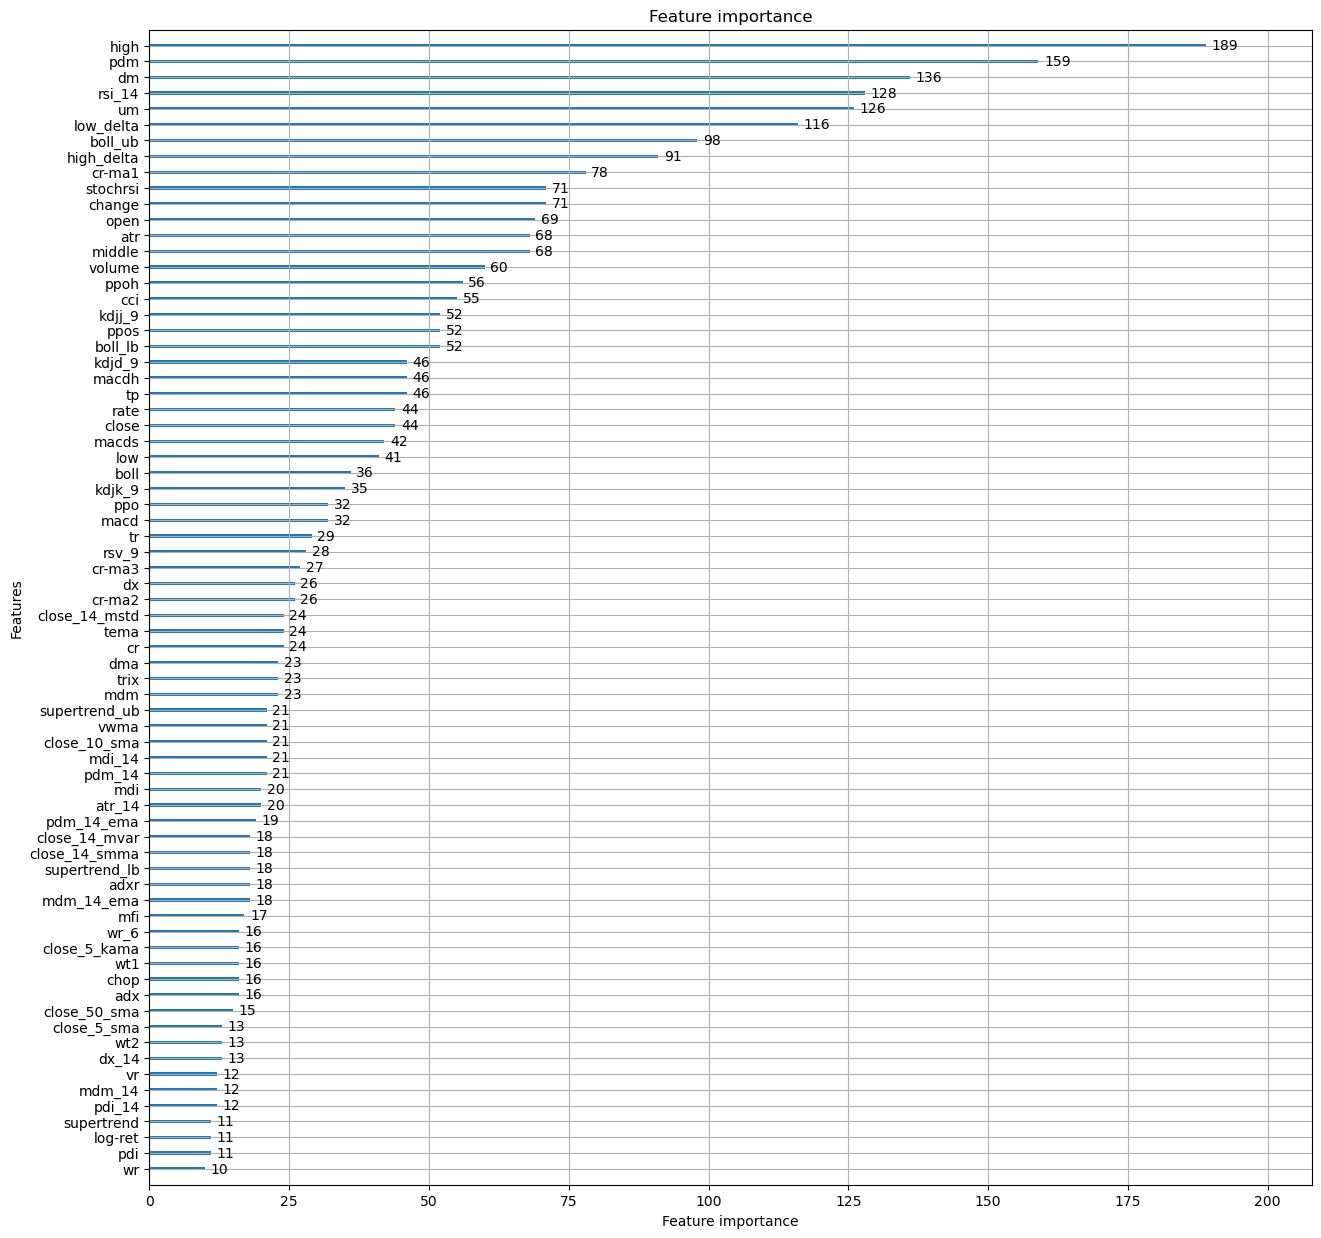

In [38]:
# Map yticklabels from Column_N to feature name.
features = X_y.drop(columns=['y']).columns
dict_features = dict(enumerate(features))

ax = lightgbm.plot_importance(model, figsize=(15, 15))

Text_yticklabels = list(ax.get_yticklabels())
lst_yticklabels = [ Text_yticklabels[i].get_text().split('_')[-1] for i in range(len(Text_yticklabels))]
lst_yticklabels = [ dict_features[int(i)] for i in lst_yticklabels]

ax.set_yticklabels(lst_yticklabels)
# print(Text_yticklabels)
# print(dict_features)
plt.show()

In [39]:
# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
features = []
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", X_y.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
        features.append(X_y.columns[i])
    else:
        print("Doesn't pass the test: ",
              X_y.columns[i], " - Ranking: ", feat_selector.ranking_[i])


------Support and Ranking for each feature------
Doesn't pass the test:  open  - Ranking:  20
Doesn't pass the test:  high  - Ranking:  24
Doesn't pass the test:  low  - Ranking:  27
Doesn't pass the test:  close  - Ranking:  28
Passes the test:  volume  - Ranking:  1
Passes the test:  change  - Ranking:  1
Passes the test:  rsi_14  - Ranking:  1
Passes the test:  stochrsi  - Ranking:  1
Doesn't pass the test:  rate  - Ranking:  40
Doesn't pass the test:  middle  - Ranking:  34
Doesn't pass the test:  tp  - Ranking:  40
Doesn't pass the test:  boll  - Ranking:  26
Doesn't pass the test:  boll_ub  - Ranking:  24
Doesn't pass the test:  boll_lb  - Ranking:  22
Doesn't pass the test:  macd  - Ranking:  13
Doesn't pass the test:  macds  - Ranking:  12
Doesn't pass the test:  macdh  - Ranking:  8
Passes the test:  ppo  - Ranking:  1
Passes the test:  ppos  - Ranking:  1
Passes the test:  ppoh  - Ranking:  1
Doesn't pass the test:  rsv_9  - Ranking:  4
Passes the test:  kdjk_9  - Ranking:  

In [40]:
dict_features = dict(enumerate(X_y.drop(columns=['y']).columns))
feature_idx = [dict_features[int(f.split('_')[-1])] for f in model.feature_name_]
df_features = pd.DataFrame(model.feature_importances_, index=feature_idx, columns=['feature_importance']) 
df_features['selected'] = 'grey'
for f in features:
    if f in df_features.index:
        df_features.loc[f, 'selected'] = 'orange'
df_features.sort_values(by='feature_importance', inplace=True, ascending=False)

<AxesSubplot: xlabel='feature_importance'>

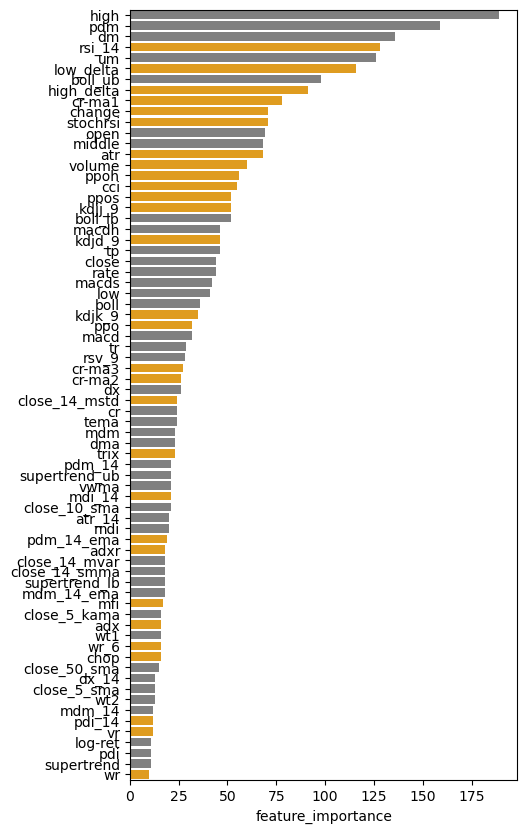

In [41]:
f, ax = plt.subplots(figsize=(5, 10))
sns.barplot(data=df_features, x='feature_importance', y=df_features.index, palette=df_features.selected)

In [42]:
N_FEATURES = 10
list_features_selected = df_features[df_features['selected'] == 'orange'].iloc[:N_FEATURES].index.to_list()
' '.join(list_features_selected)

'rsi_14 low_delta high_delta cr-ma1 change stochrsi atr volume ppoh cci'

Features selected with random forest:
* volume
* ppo
* cr-ma3
* trix 
* log_diff_high
* log_diff_low
* log_diff_open
* log_close/open

# Preprocess data

In [43]:
# Add 'close' to feature list
feature_list = 'rsi_14 low_delta high_delta cr-ma1 change stochrsi atr volume ppoh cci close'
feature_list = feature_list.split(' ')

In [44]:
df_dict = {}

_, _, files = next(os.walk(CLEAN_DATA_DIR))
for file in files:
    # skip if already exists
    processed_file_path = os.path.join(PREPROCESSED_CSI300_DIR, file)
    if os.path.exists(processed_file_path):
        continue
    
    # load
    clean_file_path = os.path.join(CLEAN_DATA_DIR, file)
    stats = pd.read_csv(clean_file_path, index_col=False)
    df = pd.DataFrame(index=stats['date'])

    stats = stockstats.StockDataFrame.retype(stats)
    for f in feature_list:
        df[f] = stats[f]

    n_rows = df.shape[0]
    # Drop nan, inf
    df.replace([-np.inf, np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    print(f'{file}\'s row number: before {n_rows}, after {df.shape[0]}')

    if df.shape[0] < (1 - NA_THRESHOLD) * n_rows:
        print(f'{file}: NA ratio {1 - (df.shape[0] - n_rows)}, droped.')
    else:
        # save
        df.reset_index(inplace=True)
        df.to_csv(processed_file_path, index=False)
        tic = file.split('.')[0]
        df_dict[tic] = df.copy()

000001.SZ.csv's row number: before 3561, after 3559
000002.SZ.csv's row number: before 3477, after 3475
000063.SZ.csv's row number: before 3534, after 3532
000069.SZ.csv's row number: before 3566, after 3564
000100.SZ.csv's row number: before 3398, after 3396
000157.SZ.csv's row number: before 3558, after 3556
000166.SZ.csv's row number: before 3372, after 3365
000301.SZ.csv's row number: before 3450, after 3448
000338.SZ.csv's row number: before 3578, after 3576
000425.SZ.csv's row number: before 3543, after 3537
000538.SZ.csv's row number: before 3462, after 3460
000568.SZ.csv's row number: before 3603, after 3601
000596.SZ.csv's row number: before 3628, after 3626
000625.SZ.csv's row number: before 3434, after 3432
000651.SZ.csv's row number: before 3464, after 3461
000661.SZ.csv's row number: before 3583, after 3581
000708.SZ.csv's row number: before 3517, after 3514
000725.SZ.csv's row number: before 3601, after 3599
000733.SZ.csv's row number: before 3600, after 3598
000768.SZ.cs

# Setup environment

In [3]:
def env_factory(dfs: List[pd.DataFrame]) -> SingleStockTradingEnv:
    '''wrap single stock trading environment with monitor.'''
    return Monitor(SingleStockTradingEnv(dfs, 1000_000, stack_frame=10))

In [4]:
# Load data
df_dict = {}
_, _, files = next(os.walk(PREPROCESSED_DATA_DIR))
for file in files:
    processed_file_path = os.path.join(PREPROCESSED_DATA_DIR, file)   
    df = pd.read_csv(processed_file_path, index_col=False)
    assert df.isna().sum().sum() == 0, f'Nan found in {file}.'
    tic = file.split('.')[0]
    df_dict[tic] = df.copy()

In [5]:
# Split data
df_dict_train = dict()
df_dict_test = dict()
df_dict_trade = dict()

TEST_START_DAY = pd.to_datetime(TEST_START_DAY, format='%Y-%m-%d')
TRADE_START_DAY = pd.to_datetime(TRADE_START_DAY, format='%Y-%m-%d')

for tic, df in df_dict.items():
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
    df_dict_train[tic] = df.loc[df.date < TEST_START_DAY].sort_index(ascending=True).copy()
    df_dict_test[tic] = df.loc[(df.date >= TEST_START_DAY) & (df.date < TRADE_START_DAY)].sort_index(ascending=True).copy()
    df_dict_trade[tic] = df.loc[df.date >= TRADE_START_DAY].sort_index(ascending=True).copy()

# create env
env_train = env_factory(list(df_dict_train.values()))
env_test = env_factory(list(df_dict_test.values()))
env_trade = env_factory(list(df_dict_trade.values()))

# Hyper parameter tuning

In [6]:
VERBOSE = 0

In [11]:
def objective_factory(
    model_name: str, 
    model_class: Type[BaseAlgorithm], 
    sample_param_func: Callable[[optuna.Trial], Tuple[Dict, int]],
    ) -> Callable[[optuna.Trial], float]:
    
    def objective(trial: optuna.Trial):
        model_path = os.path.join(MODEL_DIR, model_name)
        model_path = os.path.join(model_path, f'trial_{trial.number}_best_model')
        tb_log_path = os.path.join(TENSORBOARD_LOG_DIR, model_name)
        check_and_make_directories([model_path, tb_log_path])

        # Create model with sampled hyperparameters and 
        # train it with early stop callback    
        hyperparameters, total_timesteps = sample_param_func(trial)
        hyperparameters['tensorboard_log'] = tb_log_path

        model = model_class('MlpPolicy', env_train, **hyperparameters)

        stop_train_callback = StopTrainingOnNoModelImprovement(
            max_no_improvement_evals=4, min_evals=2, verbose=VERBOSE)
        eval_callback = MaskableEvalCallback(
            env_test, 
            callback_after_eval=stop_train_callback,
            n_eval_episodes=3,
            eval_freq=10000,
            best_model_save_path=model_path, 
            verbose=VERBOSE
            )
        try:
            model.learn(total_timesteps=total_timesteps, 
                tb_log_name=f'{model_name}_{trial.number}', callback=eval_callback)
        except ValueError as e:
            print(e)
            return -999

        # validation
        mean_reward, _ = evaluate_policy(model, env_test, n_eval_episodes=3)

        return mean_reward

    return objective

In [12]:
def tune(
    model_name: str, 
    model_class: Type[BaseAlgorithm],
    sample_param_func: Callable[[optuna.Trial], Any],
    n_trials: int = 100, 
    callbacks: List[Callable] = None
    ) -> optuna.Study:

    sampler = optuna.samplers.TPESampler(seed=None)
    objective = objective_factory(model_name, model_class, sample_param_func)

    study = optuna.create_study(
        study_name=f'{model_name}_study', 
        direction='maximize',
        sampler=sampler,
        pruner=optuna.pruners.HyperbandPruner()
        )
    study.optimize(
        objective, 
        n_trials=n_trials,
        callbacks=callbacks,
        )

    return study

In [ ]:
# study_mppo = tune('MaskablePPO', MaskablePPO, \
#     sample_param_func=sample_mppo_param)
study_mdqn = tune('MaskableDQN', MaskableDQN, \
    sample_param_func=sample_mdqn_param)
# study_mppo = tune('MaskableQRDQN', MaskableQRDQN, \
#     sample_param_func=sample_mqrdqn_param)
# study_mdqn = tune('MaskableIQN', MaskableIQN, \
#     sample_param_func=sample_miqn_param)

In [ ]:
plot_optimization_history(study_mdqn)
plot_param_importances(study_mdqn)

# Train models

In [ ]:
#study = optuna.load_study(study_name='')

In [26]:
log_dir = os.path.join(TENSORBOARD_LOG_DIR, 'MaskablePPO')
VERBOSE = 1

In [27]:
model = MaskablePPO(
    'MlpPolicy',
    env_train,
    learning_rate=3e-3,
    n_steps=2 ** 8,
    batch_size=2 ** 6,
    n_epochs=5,
    gamma=1,
    ent_coef=.5,
    policy_kwargs={
        'net_arch': [2 ** 7] * 5,
    },
    verbose=VERBOSE,
    tensorboard_log=log_dir,
    seed=114
)
eval_callback = MaskableEvalCallback(
    env_test, 
    n_eval_episodes=3,
    eval_freq=8000,
    verbose=VERBOSE
    )
model.learn(total_timesteps=2000 * 100, callback=eval_callback, tb_log_name='maskable_ppo_train')

Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to tensorboard_log\MaskablePPO\maskable_ppo_train_2
----------------------------
| time/              |     |
|    fps             | 438 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 256 |
----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 410        |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 512        |
| train/                  |            |
|    approx_kl            | 0.00833137 |
|    clip_fraction        | 0.104      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.683     |
|    explained_variance   | -1.11      |
|    learning_rate        | 0.003      |
|    loss                 | -0.31      |
|    n_updates            | 5          |
|    policy_gradient_loss | -0.0024    |
|    value_loss           | 0

In [10]:
model.save('./models/trained/MaskablePPO.pth')

c:\ProgramData\Miniconda3\envs\FTL\lib\site-packages\stable_baselines3\common\save_util.py:278: UserWarning: Path 'models\trained' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


# Backtest

In [9]:
df_dict_trade.keys()

dict_keys(['000001', '000002', '000063', '000069', '000100', '000157', '000166', '000301', '000338', '000425', '000538', '000568', '000596', '000625', '000651', '000661', '000708', '000723', '000725', '000733', '000768', '000786', '000800', '000858', '000876', '000877', '000895', '000938', '000963', '000977', '001979', '002001', '002007', '002008', '002027', '002032', '002049', '002050', '002064', '002074', '002120', '002142', '002179', '002180', '002202', '002230', '002236', '002241', '002271', '600000', '600009', '600010', '600011', '600015', '600016', '600018', '600019', '600028', '600029', '600030', '600031', '600036', '600039', '600048', '600050', '600061', '600085', '600089', '600104', '600111', '600115', '600132', '600150', '600176', '600183', '600188', '600196', '600219', '600233', '600276', '600309', '600332', '600346', '600362', '600383', '600406', '600426', '600436', '600438', '600460', '600519', '600547', '600570', '600584', '600585', '600588', '600600', '600606', '600660',

In [8]:
model = MaskablePPO.load('./models/trained/MaskablePPO.pth')

In [28]:
keys = random.sample(df_dict_train.keys(), 20)
for key in keys:
    df_t = df_dict_train[key]
    list_asset, actions = simulate_trading_masked(env_factory([df_t]), model)
    print(key, list_asset[-1], df_t.shape[0], sum(actions))

C:\Users\Wu Lingfeng\AppData\Local\Temp\ipykernel_17828\833033715.py:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  keys = random.sample(df_dict_train.keys(), 20)


600519 5000000.0 2187 2177
600219 5000000.0 2090 2080
600845 5000000.0 2129 2119
600196 5000000.0 2172 2162
000301 5000000.0 2178 2168
601006 5000000.0 2171 2161
000938 5000000.0 2026 2016
000895 5000000.0 1993 1983
000596 5000000.0 2183 2173
600760 5000000.0 2031 2021
600115 5000000.0 2121 2111
000538 5000000.0 2071 2061
600188 5000000.0 2179 2169
002064 5000000.0 2183 2173
600795 5000000.0 2159 2149
600276 5000000.0 2187 2177
601628 5000000.0 2184 2174
002179 5000000.0 2181 2171
601169 5000000.0 2152 2142
600837 5000000.0 2178 2168


In [ ]:
sr_asset = pd.Series(list_asset)
sr_return = get_daily_return(sr_asset)
backtest_stats(sr_return)
sr_baseline_return = get_daily_return(df_t.close).dropna()
sr_baseline_return = sr_baseline_return[len(sr_baseline_return) - len(sr_asset):]
backtest_stats(sr_baseline_return)
%matplotlib inline
sr_date = df_t.date
sr_date = sr_date[len(sr_date) - len(sr_asset):]
sr_return.set_axis(sr_date, inplace=True)
sr_baseline_return.set_axis(sr_date, inplace=True)
backtest_plot(sr_return, sr_baseline_return)
sum(actions)

# Plot

# Result

## Hyperparameter tuning for maskable PPO

[I 2023-01-30 11:35:09,452] A new study created in memory with name: MaskablePPO_study
[I 2023-01-30 11:45:22,296] Trial 0 finished with value: -1.0710616666666666 and parameters: {'learning_rate_3_exp': -4, 'n_steps_2exp': 2, 'batch_size_2exp': 5, 'n_epochs': 3, 'net_arch_dim_2exp': 10, 'net_arch_layers': 4}. Best is trial 0 with value: -1.0710616666666666.
[I 2023-01-30 11:54:56,256] Trial 1 finished with value: -0.2739243333333334 and parameters: {'learning_rate_3_exp': -4, 'n_steps_2exp': 5, 'batch_size_2exp': 7, 'n_epochs': 2, 'net_arch_dim_2exp': 7, 'net_arch_layers': 3}. Best is trial 1 with value: -0.2739243333333334.
[I 2023-01-30 11:59:04,286] Trial 2 finished with value: -0.7405313333333333 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 7, 'batch_size_2exp': 8, 'n_epochs': 1, 'net_arch_dim_2exp': 7, 'net_arch_layers': 3}. Best is trial 1 with value: -0.2739243333333334.
[I 2023-01-30 12:07:29,519] Trial 3 finished with value: -0.3807473333333333 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 3, 'batch_size_2exp': 8, 'n_epochs': 5, 'net_arch_dim_2exp': 6, 'net_arch_layers': 3}. Best is trial 1 with value: -0.2739243333333334.
[I 2023-01-30 12:14:18,185] Trial 4 finished with value: -1.4296143333333333 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 5, 'batch_size_2exp': 6, 'n_epochs': 4, 'net_arch_dim_2exp': 9, 'net_arch_layers': 5}. Best is trial 1 with value: -0.2739243333333334.
[I 2023-01-30 12:27:19,143] Trial 5 finished with value: -1.0494126666666668 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 4, 'batch_size_2exp': 7, 'n_epochs': 4, 'net_arch_dim_2exp': 7, 'net_arch_layers': 4}. Best is trial 1 with value: -0.2739243333333334.
[I 2023-01-30 12:34:46,817] Trial 6 finished with value: -0.2175826666666667 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 3, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 3}. Best is trial 6 with value: -0.2175826666666667.
[I 2023-01-30 12:34:46,989] Trial 7 finished with value: -999.0 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 0, 'batch_size_2exp': 5, 'n_epochs': 1, 'net_arch_dim_2exp': 8, 'net_arch_layers': 4}. Best is trial 6 with value: -0.2175826666666667.
Expected parameter logits (Tensor of shape (1, 3)) of distribution MaskableCategorical(logits: torch.Size([1, 3])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan]], device='cuda:0')
[I 2023-01-30 12:40:39,196] Trial 8 finished with value: 0.139528 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 8, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 7, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 12:44:18,919] Trial 9 finished with value: -0.8220639999999998 and parameters: {'learning_rate_3_exp': -4, 'n_steps_2exp': 7, 'batch_size_2exp': 8, 'n_epochs': 2, 'net_arch_dim_2exp': 7, 'net_arch_layers': 3}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 12:48:21,233] Trial 10 finished with value: 0.005568666666666666 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 8, 'batch_size_2exp': 6, 'n_epochs': 4, 'net_arch_dim_2exp': 6, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 12:58:03,468] Trial 11 finished with value: -0.8772513333333333 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 8, 'batch_size_2exp': 6, 'n_epochs': 4, 'net_arch_dim_2exp': 6, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 13:05:05,425] Trial 12 finished with value: -0.5665723333333333 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 8, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 6, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 13:09:48,089] Trial 13 finished with value: -0.25151299999999993 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 6, 'batch_size_2exp': 6, 'n_epochs': 4, 'net_arch_dim_2exp': 8, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 13:18:46,623] Trial 14 finished with value: -1.2781556666666667 and parameters: {'learning_rate_3_exp': -4, 'n_steps_2exp': 8, 'batch_size_2exp': 5, 'n_epochs': 3, 'net_arch_dim_2exp': 6, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 13:25:25,358] Trial 15 finished with value: -1.2174103333333333 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 6, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 7, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 13:29:13,929] Trial 16 finished with value: -0.38875166666666666 and parameters: {'learning_rate_3_exp': -4, 'n_steps_2exp': 7, 'batch_size_2exp': 7, 'n_epochs': 4, 'net_arch_dim_2exp': 8, 'net_arch_layers': 4}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 13:29:14,213] Trial 17 finished with value: -999.0 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 0, 'batch_size_2exp': 5, 'n_epochs': 5, 'net_arch_dim_2exp': 9, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
Expected parameter logits (Tensor of shape (1, 3)) of distribution MaskableCategorical(logits: torch.Size([1, 3])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan]], device='cuda:0', grad_fn=<SubBackward0>)
[I 2023-01-30 13:33:41,079] Trial 18 finished with value: -0.515313 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 6, 'batch_size_2exp': 6, 'n_epochs': 3, 'net_arch_dim_2exp': 6, 'net_arch_layers': 4}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 13:37:33,111] Trial 19 finished with value: -0.7629226666666667 and parameters: {'learning_rate_3_exp': -4, 'n_steps_2exp': 8, 'batch_size_2exp': 7, 'n_epochs': 4, 'net_arch_dim_2exp': 8, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 13:41:35,566] Trial 20 finished with value: -0.6497763333333334 and parameters: {'learning_rate_3_exp': -4, 'n_steps_2exp': 5, 'batch_size_2exp': 5, 'n_epochs': 2, 'net_arch_dim_2exp': 7, 'net_arch_layers': 4}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 14:00:16,185] Trial 21 finished with value: -0.3992253333333333 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 2, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 4}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 14:08:04,275] Trial 22 finished with value: -1.0690483333333332 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 4, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 9, 'net_arch_layers': 3}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 14:25:59,409] Trial 23 finished with value: -0.030084666666666666 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 2, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 14:45:40,132] Trial 24 finished with value: -1.3744766666666666 and parameters: {'learning_rate_3_exp': -4, 'n_steps_2exp': 1, 'batch_size_2exp': 6, 'n_epochs': 4, 'net_arch_dim_2exp': 6, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 15:23:03,830] Trial 25 finished with value: -1.7653846666666666 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 1, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 9, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 15:28:30,068] Trial 26 finished with value: -0.7855256666666666 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 7, 'batch_size_2exp': 6, 'n_epochs': 4, 'net_arch_dim_2exp': 8, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 15:38:54,512] Trial 27 finished with value: -0.6224313333333333 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 3, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 7, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 15:49:41,475] Trial 28 finished with value: -0.3991933333333333 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 2, 'batch_size_2exp': 8, 'n_epochs': 4, 'net_arch_dim_2exp': 6, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 16:20:58,663] Trial 29 finished with value: -1.0415336666666666 and parameters: {'learning_rate_3_exp': -4, 'n_steps_2exp': 1, 'batch_size_2exp': 5, 'n_epochs': 3, 'net_arch_dim_2exp': 10, 'net_arch_layers': 4}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 16:30:02,294] Trial 30 finished with value: -1.4698586666666669 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 4, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 16:43:21,658] Trial 31 finished with value: 0.02088833333333333 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 3, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 3}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 17:00:20,585] Trial 32 finished with value: -0.8848716666666666 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 2, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 17:15:36,529] Trial 33 finished with value: -0.019853 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 3, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 9, 'net_arch_layers': 3}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 17:22:31,901] Trial 34 finished with value: -0.44696099999999994 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 3, 'batch_size_2exp': 8, 'n_epochs': 4, 'net_arch_dim_2exp': 9, 'net_arch_layers': 3}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 17:31:47,434] Trial 35 finished with value: -0.17429333333333333 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 5, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 9, 'net_arch_layers': 3}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 17:37:08,776] Trial 36 finished with value: -0.413024 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 4, 'batch_size_2exp': 6, 'n_epochs': 4, 'net_arch_dim_2exp': 9, 'net_arch_layers': 3}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 17:45:36,550] Trial 37 finished with value: -0.5693386666666667 and parameters: {'learning_rate_3_exp': -4, 'n_steps_2exp': 3, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 8, 'net_arch_layers': 3}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 17:52:27,447] Trial 38 finished with value: -0.32163899999999995 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 6, 'batch_size_2exp': 6, 'n_epochs': 4, 'net_arch_dim_2exp': 7, 'net_arch_layers': 3}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 17:58:10,626] Trial 39 finished with value: -0.39240733333333333 and parameters: {'learning_rate_3_exp': -4, 'n_steps_2exp': 7, 'batch_size_2exp': 8, 'n_epochs': 1, 'net_arch_dim_2exp': 7, 'net_arch_layers': 3}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 18:02:35,272] Trial 40 finished with value: -0.5711713333333334 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 5, 'batch_size_2exp': 7, 'n_epochs': 3, 'net_arch_dim_2exp': 10, 'net_arch_layers': 4}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 18:12:29,331] Trial 41 finished with value: -0.09938799999999999 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 3, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 3}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 18:30:15,883] Trial 42 finished with value: -0.28991866666666666 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 2, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 4}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 18:38:42,726] Trial 43 finished with value: -0.4875106666666667 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 3, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 9, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 18:49:52,209] Trial 44 finished with value: -1.0828693333333332 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 4, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 4}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 19:35:10,493] Trial 45 finished with value: -0.6904150000000001 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 1, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 19:45:15,404] Trial 46 finished with value: -0.8048216666666667 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 2, 'batch_size_2exp': 8, 'n_epochs': 4, 'net_arch_dim_2exp': 8, 'net_arch_layers': 3}. Best is trial 8 with value: 0.139528.
[I 2023-01-30 19:49:33,910] Trial 47 finished with value: 0.20815533333333333 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 8, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 7, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 19:57:19,009] Trial 48 finished with value: -0.47554466666666667 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 8, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 7, 'net_arch_layers': 4}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 20:04:59,025] Trial 49 finished with value: -0.7375536666666668 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 8, 'batch_size_2exp': 6, 'n_epochs': 4, 'net_arch_dim_2exp': 7, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 20:11:10,333] Trial 50 finished with value: -0.9862456666666667 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 7, 'batch_size_2exp': 5, 'n_epochs': 4, 'net_arch_dim_2exp': 6, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 20:19:04,843] Trial 51 finished with value: -0.14732266666666669 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 8, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 6, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 20:26:01,710] Trial 52 finished with value: -0.7422023333333333 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 7, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 8, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 20:30:08,180] Trial 53 finished with value: -0.5128739999999999 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 8, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 9, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 20:37:32,129] Trial 54 finished with value: -0.9192929999999998 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 8, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 7, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 20:52:52,159] Trial 55 finished with value: -0.131528 and parameters: {'learning_rate_3_exp': -4, 'n_steps_2exp': 3, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 8, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 20:59:14,149] Trial 56 finished with value: -1.0313139999999998 and parameters: {'learning_rate_3_exp': -4, 'n_steps_2exp': 7, 'batch_size_2exp': 6, 'n_epochs': 2, 'net_arch_dim_2exp': 6, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 21:10:03,209] Trial 57 finished with value: -1.6049653333333334 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 4, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 21:17:36,516] Trial 58 finished with value: -0.27793833333333334 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 6, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 9, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 21:17:36,563] Trial 59 finished with value: -999.0 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 0, 'batch_size_2exp': 7, 'n_epochs': 4, 'net_arch_dim_2exp': 7, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
Expected parameter logits (Tensor of shape (1, 3)) of distribution MaskableCategorical(logits: torch.Size([1, 3])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan]], device='cuda:0', grad_fn=<SubBackward0>)
[I 2023-01-30 21:46:16,107] Trial 60 finished with value: -0.49509800000000004 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 2, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 6, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 21:56:03,564] Trial 61 finished with value: -0.6322530000000001 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 3, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 22:12:22,781] Trial 62 finished with value: -0.7224483333333332 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 3, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 22:30:54,019] Trial 63 finished with value: 0.04822266666666666 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 3, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 22:42:31,342] Trial 64 finished with value: 0.003159666666666665 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 2, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 22:47:32,895] Trial 65 finished with value: -0.40266699999999994 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 8, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 22:53:58,820] Trial 66 finished with value: -0.477679 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 4, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 9, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 23:32:58,481] Trial 67 finished with value: -1.2847836666666668 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 1, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 23:42:40,603] Trial 68 finished with value: -0.48326399999999997 and parameters: {'learning_rate_3_exp': -4, 'n_steps_2exp': 2, 'batch_size_2exp': 5, 'n_epochs': 4, 'net_arch_dim_2exp': 8, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 23:54:21,760] Trial 69 finished with value: -0.39726733333333336 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 3, 'batch_size_2exp': 7, 'n_epochs': 4, 'net_arch_dim_2exp': 10, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-30 23:59:47,350] Trial 70 finished with value: -0.4848543333333333 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 4, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 7, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 00:16:09,006] Trial 71 finished with value: -0.9602633333333334 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 2, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 00:35:12,061] Trial 72 finished with value: -0.3500816666666666 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 2, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 4}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 00:43:32,720] Trial 73 finished with value: 0.007844333333333333 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 3, 'batch_size_2exp': 8, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 00:52:07,215] Trial 74 finished with value: -0.342135 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 3, 'batch_size_2exp': 8, 'n_epochs': 5, 'net_arch_dim_2exp': 9, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 00:56:10,199] Trial 75 finished with value: -0.7481516666666667 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 7, 'batch_size_2exp': 8, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 01:03:47,370] Trial 76 finished with value: -0.5838169999999999 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 3, 'batch_size_2exp': 8, 'n_epochs': 3, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 01:13:26,577] Trial 77 finished with value: -0.4263326666666667 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 3, 'batch_size_2exp': 8, 'n_epochs': 5, 'net_arch_dim_2exp': 9, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 01:19:16,797] Trial 78 finished with value: -0.5381776666666668 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 5, 'batch_size_2exp': 6, 'n_epochs': 4, 'net_arch_dim_2exp': 10, 'net_arch_layers': 4}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 01:23:02,532] Trial 79 finished with value: 0.19475166666666666 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 8, 'batch_size_2exp': 8, 'n_epochs': 5, 'net_arch_dim_2exp': 6, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 01:26:53,095] Trial 80 finished with value: -0.8212086666666667 and parameters: {'learning_rate_3_exp': -4, 'n_steps_2exp': 8, 'batch_size_2exp': 8, 'n_epochs': 5, 'net_arch_dim_2exp': 6, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 01:31:07,702] Trial 81 finished with value: -0.6204623333333333 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 8, 'batch_size_2exp': 8, 'n_epochs': 5, 'net_arch_dim_2exp': 6, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 01:34:51,587] Trial 82 finished with value: -0.5214996666666667 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 8, 'batch_size_2exp': 8, 'n_epochs': 5, 'net_arch_dim_2exp': 6, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 01:40:38,826] Trial 83 finished with value: -1.095369 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 8, 'batch_size_2exp': 8, 'n_epochs': 5, 'net_arch_dim_2exp': 6, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 01:44:33,952] Trial 84 finished with value: -0.8564336666666666 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 7, 'batch_size_2exp': 8, 'n_epochs': 5, 'net_arch_dim_2exp': 7, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 01:56:47,320] Trial 85 finished with value: -0.3596026666666667 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 4, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 6, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 02:02:02,910] Trial 86 finished with value: -0.9681890000000001 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 8, 'batch_size_2exp': 6, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 02:08:41,924] Trial 87 finished with value: -0.26260633333333333 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 3, 'batch_size_2exp': 7, 'n_epochs': 4, 'net_arch_dim_2exp': 8, 'net_arch_layers': 3}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 02:12:41,794] Trial 88 finished with value: -0.786614 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 7, 'batch_size_2exp': 7, 'n_epochs': 5, 'net_arch_dim_2exp': 7, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 02:23:07,728] Trial 89 finished with value: -0.8378396666666666 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 4, 'batch_size_2exp': 8, 'n_epochs': 5, 'net_arch_dim_2exp': 6, 'net_arch_layers': 4}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 02:48:17,021] Trial 90 finished with value: 0.007555333333333334 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 1, 'batch_size_2exp': 5, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 02:48:17,695] Trial 91 finished with value: -999.0 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 0, 'batch_size_2exp': 5, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
Expected parameter logits (Tensor of shape (1, 3)) of distribution MaskableCategorical(logits: torch.Size([1, 3])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan]], device='cuda:0', grad_fn=<SubBackward0>)
[I 2023-01-31 03:04:46,258] Trial 92 finished with value: -0.009927333333333335 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 2, 'batch_size_2exp': 5, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 03:27:55,914] Trial 93 finished with value: -0.1371403333333333 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 1, 'batch_size_2exp': 5, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 04:02:10,640] Trial 94 finished with value: -0.0028663333333333336 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 1, 'batch_size_2exp': 5, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 04:47:43,578] Trial 95 finished with value: -0.26596166666666665 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 1, 'batch_size_2exp': 5, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 05:30:27,088] Trial 96 finished with value: -0.004809666666666667 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 1, 'batch_size_2exp': 5, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
[I 2023-01-31 05:30:27,700] Trial 97 finished with value: -999.0 and parameters: {'learning_rate_3_exp': -3, 'n_steps_2exp': 0, 'batch_size_2exp': 5, 'n_epochs': 5, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.
Expected parameter logits (Tensor of shape (1, 3)) of distribution MaskableCategorical(logits: torch.Size([1, 3])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan, nan]], device='cuda:0', grad_fn=<SubBackward0>)
[I 2023-01-31 05:48:56,050] Trial 98 finished with value: -0.37979466666666667 and parameters: {'learning_rate_3_exp': -5, 'n_steps_2exp': 2, 'batch_size_2exp': 5, 'n_epochs': 4, 'net_arch_dim_2exp': 10, 'net_arch_layers': 5}. Best is trial 47 with value: 0.20815533333333333.